In [56]:
from IPython.display import display
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import gzip
import os
from alive_progress import alive_bar
from collections import defaultdict

start_year = 1800
end_year = 2000

years_Columns = list(range(start_year,end_year)) 

directory = 'C:/Users/bincl/BA-Thesis/Dataset/2gram'
chunksize_per_df = 2


In [57]:
import csv
from io import TextIOWrapper
from zipfile import ZipFile

df_3gram = pd.DataFrame(columns = years_Columns)
index = []
data_year = []

with ZipFile('C:/Users/bincl/BA-Thesis/Dataset/3gram/3_20000_nopos_sample.zip') as zf:
    with zf.open('3_20000_nopos_sample', 'r') as infile:
        file = TextIOWrapper(infile, encoding='utf-8', newline='')
        reader = csv.reader(file, delimiter= "\t" ,skipinitialspace=True,quoting=csv.QUOTE_NONE)   
        
        for i in range(0,chunksize_per_df):
            line = next(reader)
            index.append(line[0])
            
            data = [entry.split(",") for entry in line[1:]]
            year = {int(entry[0]): entry[1] for entry in data if start_year <= int(entry[0]) <= end_year}
            data_year.append(year)
            
        for i, word_data in enumerate(data_year):
            word = index[i]
            for year, value in word_data.items():
                df_3gram.at[word, year] = value

        df_3gram.fillna(0, inplace=True)

         

In [58]:
display(df_3gram)

,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
""" Bis seine",0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,10,0,1
""" -- Vorgehen",0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,4,3,5,4,8


In [59]:

def find_n_gram(direc, find):
    for filename in os.listdir(direc):
        f = os.path.join(direc, filename)
        # checking if it is a file
        if os.path.isfile(f):
            #print(f)
            with gzip.open(f,'rt', encoding='utf-8') as input:
                str_arr_csv = input.readlines()
                for line in str_arr_csv:
                    token = line.split("\t")
                    if find == token[0]:
                        return line
                        
    return "line not found" 

def start_the_search(directory,search):
    result = find_n_gram(directory,search)
    
    if result == "line not found":
        print(result)
        exit()
    result = result.strip().split("\t")
    return result

def convert_to_df(first,last):
    indexList = [first[0], last[0]]
    df = pd.DataFrame(0,index= indexList,columns = years_Columns)
    data_year = []
    
    data = [entry.split(",") for entry in first[1:]]
    data_last = [entry.split(",") for entry in last[1:]]
    year_first= {int(entry[0]): entry[1] for entry in data if start_year <= int(entry[0]) <= end_year}
    data_year.append(year_first)
    year_last = {int(entry[0]): entry[1] for entry in data_last if start_year <= int(entry[0]) <= end_year}
    data_year.append(year_last)
    #print(data_year)
    for i, word_data in enumerate(data_year):
            word = indexList[i]
            for year, value in word_data.items():
                df.at[word, year] = value
    #print(df)
    result_first = df.iloc[0]
    result_last = df.iloc[1]
    return result_first, result_last

Test function search

In [60]:
#first = start_the_search(directory,'" Bis')
#last = start_the_search(directory,'Bis seine')
#first,last = convert_to_df(first,last)
#display(first)
#display(last)

In [61]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   first = first + " " + ''.join(middle)
   last = ''.join(middle) + " " + last
   return first, last

def MLR(token,ngram):
    #print(token)
    first,last = getLowerLevelString(token)
    #print(first)
    #print(last)
    first = start_the_search(directory,first)
    last = start_the_search(directory,last)
    first, last = convert_to_df(first,last)
    X = pd.concat([first,last],axis=1)
    y = ngram.loc[token]
    reg = LinearRegression()
    reg.fit(X, y) 
    
    return reg.coef_,reg.intercept_,X

def buildApproximation(c1,c2,basevalue,df):
    df = df.astype('float')
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

In [62]:
def compressWithError2gram(firstN,error,df_ngram):
    df_N_gram = df_ngram.head(firstN)
    
    result = []
    all = []
    sum = []
    with alive_bar(df_N_gram.index.values.size) as bar:
        for token in df_N_gram.index.values:
            coef,intercept,dfAprox = MLR(token,df_N_gram)
            c1,c2 = coef
            df = buildApproximation(c1,c2,intercept,dfAprox)
            dfOriginal = pd.DataFrame()
            dfOriginal['values'] = df_ngram.loc[token]
            dfOriginal['values'] = dfOriginal['values'].apply(pd.to_numeric, errors='coerce')
            #dfOriginal= pd.to_numeric(dfOriginal)
            dfOriginal['zscore'] = zscore(dfOriginal)
            df['zscore'] = zscore(df['approximation'])
            
            sum.append(pd.to_numeric(dfOriginal['values']).sum()) 
            
            rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
            #rmse = mean_squared_error(dfOriginal, df['approximation'])
            if rmse <= error:
                result.append([token,rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
            all.append(rmse)    
            bar()
    return result, all, sum


In [63]:
result, all, sum = compressWithError2gram(chunksize_per_df,0.05, df_3gram)
print(len(result))


on 0: C:\Users\bincl\AppData\Local\Temp\ipykernel_3984\3373694177.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
        df.at[word, year] = value
on 1: C:\Users\bincl\AppData\Local\Temp\ipykernel_3984\3373694177.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
        df.at[word, year] = value


|████████████████████████████████████████| 2/2 [100%] in 4:40.8 (0.01/s) 
0


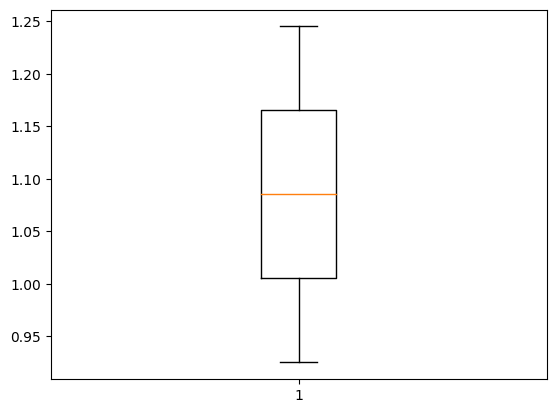

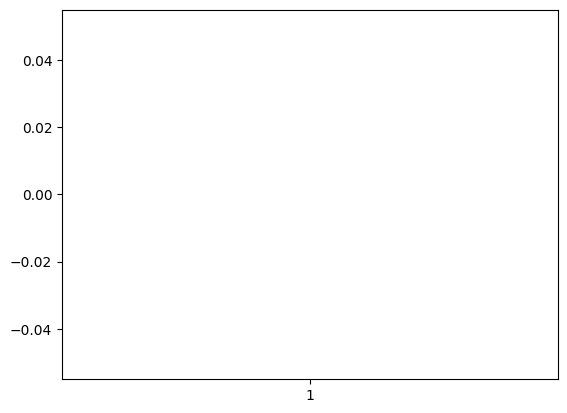

<AxesSubplot: >

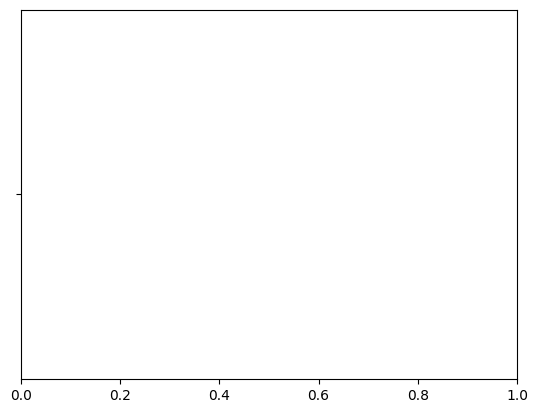

In [64]:
plt.boxplot(all)
plt.show()
rmse_with_error = []

for i in result:
    rmse_with_error.append(i[1])
plt.boxplot(rmse_with_error)
plt.show()

import seaborn as sns

sns.violinplot(x= rmse_with_error, inner="point")

<AxesSubplot: >

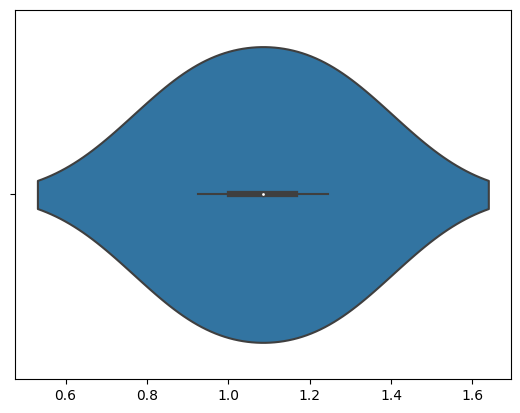

In [65]:
sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))

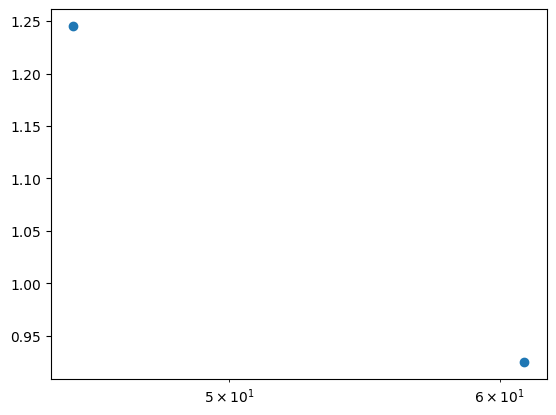

In [66]:

plt.scatter(sum, all)
plt.xscale('log')
plt.show()